In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from tqdm.notebook import tqdm

import json
import os
import time
import csv

import matplotlib.pyplot as plt
plt.rc('font', size=14)
import seaborn as sns
sns.set(style='whitegrid', color_codes=True, rc={'figure.figsize':(11,8)}, font_scale=2)

In [2]:
#os.chdir('/c/Users/matth/Documents/Coding/spotify/')

In [3]:
#!pwd

### EDA

In [4]:
df = pd.read_csv('./final/final_table.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19306 entries, 0 to 19305
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   endTime           19306 non-null  object 
 1   artistName        19306 non-null  object 
 2   trackName         19306 non-null  object 
 3   msPlayed          19306 non-null  int64  
 4   song_artist       19306 non-null  object 
 5   track_id          19306 non-null  object 
 6   danceability      19306 non-null  float64
 7   energy            19306 non-null  float64
 8   key               19306 non-null  float64
 9   loudness          19306 non-null  float64
 10  mode              19306 non-null  float64
 11  speechiness       19306 non-null  float64
 12  acousticness      19306 non-null  float64
 13  instrumentalness  19306 non-null  float64
 14  liveness          19306 non-null  float64
 15  valence           19306 non-null  float64
 16  tempo             19306 non-null  float6

In [5]:
df.drop(labels = ['song_artist','track_id'], axis=1, inplace=True)

In [6]:
for col in df.columns:
    print(col,':',len(df[col].unique()))

endTime : 9682
artistName : 1592
trackName : 2992
msPlayed : 6541
danceability : 657
energy : 778
key : 12
loudness : 2613
mode : 2
speechiness : 878
acousticness : 1697
instrumentalness : 1393
liveness : 895
valence : 922
tempo : 2855
duration_ms : 2948
time_signature : 4
genre : 263


**Categorical Variables**: key, mode (major or minor modality), time_signature, genre

**Continuous**: endTime, dancability, energy, loudness, speechiness, acousticness, intrumentalness, liveness, valence, tempo, duration

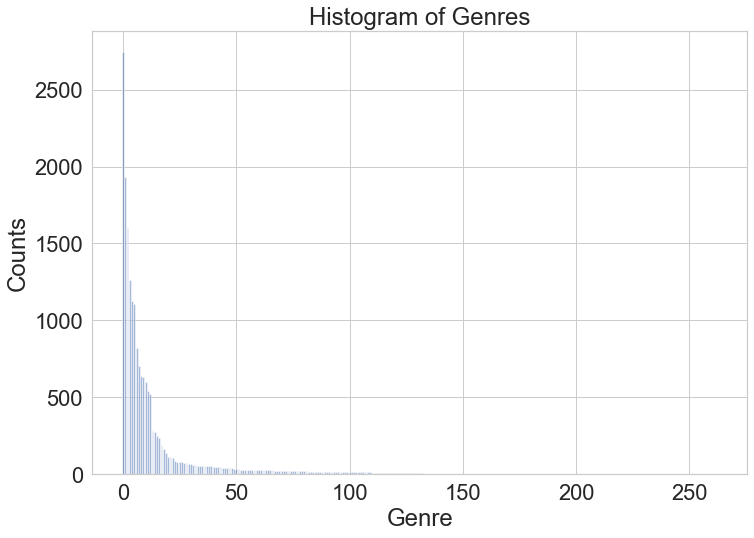

In [7]:
genre_counts = pd.DataFrame(df['genre'].value_counts())

objects = tuple(genre_counts.index)
y_pos = np.arange(len(objects))
counts = genre_counts['genre']

plt.bar(x = y_pos, height = counts, align='center', alpha=0.5)
#plt.xticks(y_pos, objects)
plt.title('Histogram of Genres')
plt.xlabel('Genre')
plt.ylabel('Counts')
#plt.xticks(fontsize=5, rotation=90)
plt.tight_layout()
plt.show()

**Findings:**
Out of the 250+ genres in the dataset, only around 20 appear more than 250 times, with the vast majority appearing less than 100 times. 

In [8]:
# number of genres which appear at least 10 times
print(genre_counts[genre_counts['genre']>=10].shape[0])
gen_min10 = genre_counts[genre_counts['genre']>=10].index.tolist() # list of genres for removing outliers later

115


In [9]:
gen_t25 = genre_counts.iloc[:25,:].index.tolist()

### Analysis
#### Pre-processing

In [10]:
# turning cat vars into one hot
dummy_col = ['key', 'mode', 'time_signature']
processing = pd.get_dummies(df, columns=dummy_col, drop_first=False) # including intercept since no standardizing
# https://stats.stackexchange.com/questions/224051/one-hot-vs-dummy-encoding-in-scikit-learn

In [11]:
# removing genres which appear less than 10 times
print('n Before removing outliers:',processing.shape[0])
processing = processing[processing['genre'].isin(gen_min10)]
print('n After removing outliers:',processing.shape[0])

n Before removing outliers: 19306
n After removing outliers: 18906


In [12]:
# label encoding genres
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
processing['genre_label'] = label_encoder.fit_transform(processing['genre'])

In [13]:
# dictionary to convert label-encoded genres back to actual genre names
revert_gen = {label: genre for (genre, label) in zip(processing['genre'],processing['genre_label'])}

In [14]:
from sklearn.model_selection import train_test_split

X = processing.drop(labels = ['endTime','artistName','trackName','msPlayed','genre','genre_label'], axis=1, inplace=False)
y = processing['genre_label']

#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.8)

In [15]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

In [16]:
skf.split(X, y)

<generator object _BaseKFold.split at 0x000001A765D1B5C8>

In [17]:
Xtr = []
ytr = []
Xte = []
yte = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    Xtr.append(X_train), Xte.append(X_test), ytr.append(y_train), yte.append(y_test)

In [18]:
X_train, X_test = Xtr[0], Xte[0]
y_train, y_test = ytr[0], yte[0]

#### Modeling Relationship between Audio Features and Genre

Testing multiple classification models without tuning.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.time()

n_neighbors = 10

classifiers = {
    "MLR": LogisticRegression(multi_class='multinomial', solver='saga'),
    "KNN": neighbors.KNeighborsClassifier(n_neighbors = n_neighbors, n_jobs = -1),
    "Tree": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "GBoost": GradientBoostingClassifier()
}

y_test_preds = dict()

print("Generating models took", time.time()-start_time) # 

In [27]:
start_time = time.time()

for name, classifier in classifiers.items():
    model = classifier.fit(X_train, y_train)
    y_test_preds[name] = [model.predict(X_test),model.predict_proba(X_test),model]
    
print("Training took", time.time()-start_time) # 898.7419912815094 s (15 min)

Training took 898.7419912815094


#### Model Evaluation

In [30]:
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix

for name in classifiers.keys():
    result = pd.DataFrame({'True':y_test,'Predict':y_test_preds[name][0]})
    result['Correct'] = np.where(result.iloc[:,0] == result.iloc[:,1],1,0)
    acc = (result['Correct'] == 1).sum()/result.shape[0]
       
    t5_acc = top_k_accuracy_score(y_test,y_test_preds[name][1], k=5)
    
    #ADD ROC AUC
    logloss = log_loss(y_test,y_test_preds[name][1])
    f1 = f1_score(y_test, y_test_preds[name][0], average='macro')
    
    
    print(name)
    print('Accuracy:', acc, '\t Top 5 Accuracy:', t5_acc)
    print('LogLoss:',logloss, '\t F1:',f1,'\n')

MLR
Accuracy: 0.14516129032258066 	 Top 5 Accuracy: 0.45716552088841883
LogLoss: 3.433093415043261 	 F1: 0.002204531537048377 

KNN
Accuracy: 0.7094130089899524 	 Top 5 Accuracy: 0.8204653622421999
LogLoss: 6.383664207530595 	 F1: 0.5764320509066517 

Tree
Accuracy: 0.8083024854574299 	 Top 5 Accuracy: 0.8093601269169751
LogLoss: 6.620997590246081 	 F1: 0.770220626662753 

RF
Accuracy: 0.8376520359598096 	 Top 5 Accuracy: 0.9063987308302486
LogLoss: 1.3871911796308127 	 F1: 0.8305843317901678 

XGBoost
Accuracy: 0.772607086197779 	 Top 5 Accuracy: 0.8984664198836594
LogLoss: 2.004542685321732 	 F1: 0.7581319516972962 



#### Feature Importances

In [ ]:
# RF
RF = y_test_preds['RF']

feature_names = X.columns
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize =(16, 9))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# Gradient Boost
GB = y_test_preds['GBoost']

feature_names = X.columns
importances = GB.feature_importances_
std = np.std([tree.feature_importances_ for b in GB.estimators_], axis=0)
boost_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize =(16, 9))
boost_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Model Tuning

#### RF and Gradient Boosting

In [ ]:
# gridsearch cv
# randomsearch cv

### Searching for New Genres via Clustering

#### K-means

**Elbow Method**

In [33]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,18906.0,0.637600,0.137663,0.067000,0.5520,0.6490,0.732000,0.972
energy,18906.0,0.700179,0.176581,0.005790,0.5950,0.7250,0.842000,0.993
key,18906.0,5.320269,3.609237,0.000000,2.0000,5.0000,8.000000,11.000
loudness,18906.0,-5.696439,2.593521,-35.072000,-6.6540,-5.4850,-4.082000,0.034
mode,18906.0,0.649053,0.477279,0.000000,0.0000,1.0000,1.000000,1.000
speechiness,18906.0,0.073621,0.061449,0.023300,0.0377,0.0523,0.085700,0.712
acousticness,18906.0,0.195492,0.231738,0.000007,0.0160,0.0954,0.304750,0.996
instrumentalness,18906.0,0.024918,0.127917,0.000000,0.0000,0.0000,0.000123,0.977
liveness,18906.0,0.177780,0.123653,0.011400,0.0957,0.1280,0.241000,0.991
valence,18906.0,0.579263,0.214458,0.026200,0.4200,0.5920,0.755000,0.977


Generating elbow took 610.1405174732208


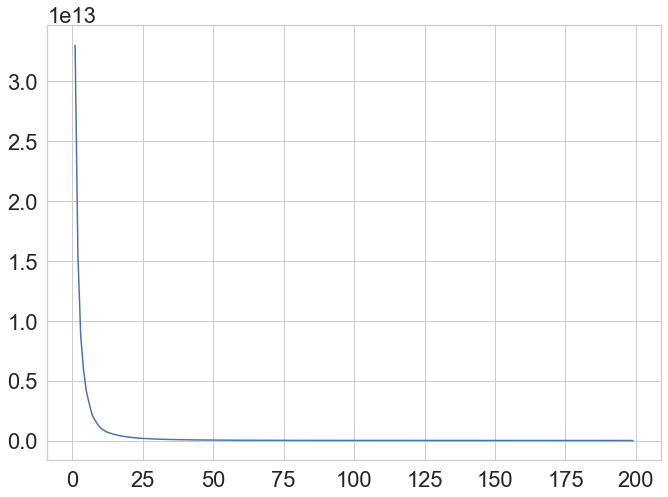

In [38]:
from sklearn.cluster import KMeans

wcss = []
start = 1
end = 200

start_time = time.time()

for i in range(start, end):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit(X)
    wcss.append(clustering.inertia_)
    
ks = list(range(start,end))
sns.lineplot(x = ks, y = wcss)

print("Generating elbow took", time.time()-start_time) # 610.1405174732208 s (12 min)


Generating elbow took 610.5756132602692


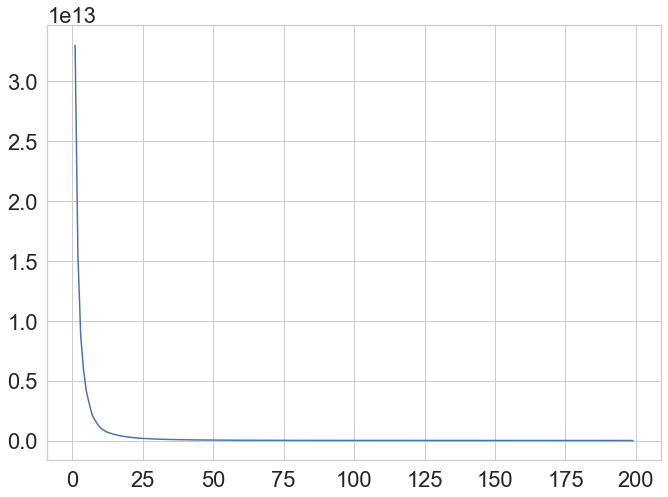

In [39]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scaled = ss.fit_transform(X)

wcss = []
start = 1
end = 200

start_time = time.time()

for i in range(start, end):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit(X)
    wcss.append(clustering.inertia_)
    
ks = list(range(start,end))
sns.lineplot(x = ks, y = wcss)

print("Generating elbow took", time.time()-start_time) # 610.5756132602692 s (12 min)

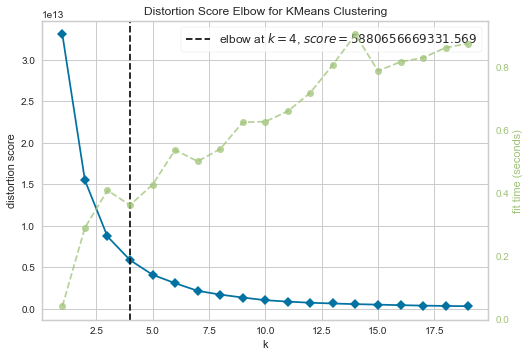

In [70]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(X)
visualizer.show()

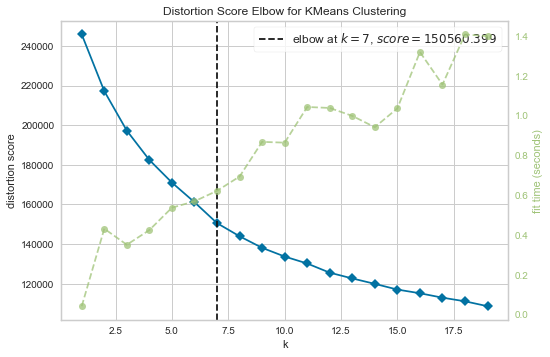

In [69]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(scaled)
visualizer.show()

**Model Refit and Assigning New Clusters**

In [71]:
final_model = KMeans(n_clusters=7, init='k-means++', random_state=42)
final_model.fit(scaled)

KMeans(n_clusters=7, random_state=42)

In [72]:
df['clusters'] = final_model.predict(scaled)

In [81]:
for x in range(0,7):
    temp = df[df['clusters']==x]
    print('Cluster',x)
    print(pd.DataFrame(temp['genre'].value_counts()).iloc[:5,:])

Cluster 0
           genre
indie        929
k-pop        720
korean       652
pop          416
indie pop    239
Cluster 1
          genre
k-pop       345
indie       255
j-pop       251
rock        142
japanese    137
Cluster 2
            genre
indie         720
j-pop         635
k-pop         268
japanese      255
electronic    221
Cluster 3
         genre
hip-hop    527
k-pop      491
korean     410
indie      321
pop        228
Cluster 4
            genre
korean        125
indie          72
soundtrack     43
k-pop          35
pop            30
Cluster 5
        genre
indie     428
lo-fi     311
pop       244
korean    205
rnb       171
Cluster 6
            genre
soundtrack     62
lo-fi          52
jazz           47
electronic     40
piano          36


In [100]:
cluster_toGen = dict()

for x in range(0,7):
    temp = df[df['clusters']==x]
    counts = pd.DataFrame(temp['genre'].value_counts())
    genre = counts.index[0]
    if(genre in list(cluster_toGen.values())):
        y=1
        while(genre in list(cluster_toGen.values())):
            genre = counts.index[y]
            y+=1
    cluster_toGen[x] = genre

In [101]:
cluster_toGen

{0: 'indie',
 1: 'k-pop',
 2: 'j-pop',
 3: 'hip-hop',
 4: 'korean',
 5: 'lo-fi',
 6: 'soundtrack'}

#### Mapping New 'Genres' Back to Original Data

In [102]:
df['new_gen'] = df['clusters'].replace(cluster_toGen)

In [107]:
df.drop('genre_label',inplace=True)

KeyError: "['genre_label'] not found in axis"

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18906 entries, 1 to 19305
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   endTime           18906 non-null  object 
 1   artistName        18906 non-null  object 
 2   trackName         18906 non-null  object 
 3   msPlayed          18906 non-null  int64  
 4   danceability      18906 non-null  float64
 5   energy            18906 non-null  float64
 6   key               18906 non-null  float64
 7   loudness          18906 non-null  float64
 8   mode              18906 non-null  float64
 9   speechiness       18906 non-null  float64
 10  acousticness      18906 non-null  float64
 11  instrumentalness  18906 non-null  float64
 12  liveness          18906 non-null  float64
 13  valence           18906 non-null  float64
 14  tempo             18906 non-null  float64
 15  duration_ms       18906 non-null  float64
 16  time_signature    18906 non-null  float6

In [ ]:
df.to_csv(path_or_buf = './final/final_newGen.csv', index = False)